In [1]:
# main_vac_osc script 

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator
# from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit.primitives import BackendSampler
import sys
import os


In [2]:
import qiskit 
qiskit.version.get_version_info()

'1.1.1'

In [3]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.24.1'

In [16]:
from qiskit import transpile

In [4]:

# Load the API key from the environment variable
api_key = os.getenv('IONQ_API_KEY')

In [5]:
from qiskit_ionq import IonQProvider
# provider = IonQProvider()
api_key = "zneojFDA2Je63szoO1GYFi7EwQO9FEnQ"
provider = IonQProvider(api_key)
print(provider.backends())


[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [6]:
# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit
from constants import hbar, c , eV, MeV, GeV, G_F, kB

In [7]:

def initialize_parameters():
    N_sites = 4  # Number of qubits
    delta_m_squared = np.pi
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.full(N_sites // 2, delta_m_squared)
    omega = np.concatenate((omega_a, omega_b))
    shots = 1024
    # backend = AerSimulator(method='automatic')
    backend = provider.get_backend("simulator")
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 10  # Total time
    times = np.arange(0, ttotal, τ)  # Define time steps
    Δx = 1E-3 # length of the box of interacting neutrinos at a site in cm #variable
    L = 1 # cm # not being used in this test but defined to keep the evolve function arguments consistent.
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = np.pi / 4  # mixing_angle in radians
    # Initialize an array of zeros for all N_sites particles
    mu = np.zeros(N_sites)

    # Create an array of dimension N and fill it with the value 1/(sqrt(2) * G_F). This is the number of neutrinos.
    N = np.full(N_sites, (Δx**3) / (np.sqrt(2) * G_F))

    # Create a B vector which would be same for all N particles
    B = np.array([np.sin(2 * theta_nu), 0, -np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)

    # Generate x, y, and z arrays
    x = np.random.rand(N_sites)
    y = np.random.rand(N_sites)
    z = np.zeros(N_sites)

    # Generate an Nx3 array for p with ones as values
    p = np.ones((N_sites, 3))

    # All of the sites are neutrinos, energy_sign array
    energy_sign = np.ones(N_sites)
    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file


    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times

In [17]:
def simulate(times, omega, N_sites, H, backend, shots, τ, tolerance):
    sigma_z_values = []
    expected_sz_array = []

    for t in times:
        expected_sz = [-1 * np.cos(omega_i * t) for omega_i in omega]
        expected_sz_array.append(np.mean(expected_sz) if expected_sz else None)

        qc = evolve_and_measure_circuit(t, H, N_sites)
        # job = backend.run(qc, shots=shots)
        # result = job.result()
        # counts = result.get_counts(qc)
        qc = transpile(qc, backend=backend)
        job = backend.run(qc, shots=shots)
        counts = job.get_counts()
        
        # Calculate expectation value of sigma_z for the first qubit
        sigma_z = 0
        for outcome, count in counts.items():
            if outcome[0] == '0':
                sigma_z += count / shots
            else:
                sigma_z -= count / shots
        sigma_z_values.append(sigma_z)
 
    
    assert all(abs(np.array(sigma_z_values) - np.array(expected_sz_array)) < tolerance), "Assertion failed: values differ more than tolerance"

    return sigma_z_values, expected_sz_array

In [18]:

def plot_results(times, sigma_z_values, expected_sz_array, N_sites):
    plt.plot(times, sigma_z_values, label='Simulated $\sigma_z$')
    plt.plot(times, expected_sz_array, label='Expected $\sigma_z$', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('$\sigma_z$')
    plt.title(f'$\sigma_z$ vs Time ({N_sites} Qubits, $H_{{vac}}$ Term)')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [19]:

def main():
    N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times= initialize_parameters()
    H = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
    sigma_z_values, expected_sz_array = simulate(times, omega, N_sites, H, backend, shots, τ, tolerance)
    plot_results(times, sigma_z_values, expected_sz_array, N_sites)

/home/zohalaraib/.local/lib/python3.10/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate definition for cnot can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(
/home/zohalaraib/.local/lib/python3.10/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate definition for mcx_gray can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(
/home/zohalaraib/.local/lib/python3.10/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate definition for i can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(
/home/zohalaraib/.local/lib/python3.10/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate 

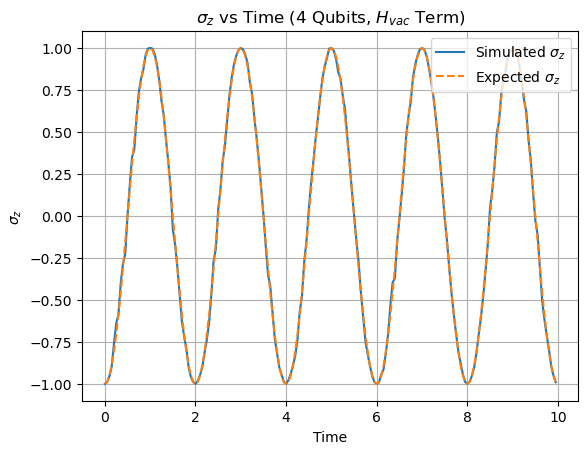

In [20]:
if __name__ == "__main__":
    main()
